# **Automated Trading Operations**

In [114]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
import scipy.stats as scs
import pickle
import tpqoa

### **Capital Management 101: Kelly Criterion**

-The Kelly criterion (also known as the scientific gambling method) is a formula which helps investors and gamblers size their bets

-It is valid when the expected returns are known...

-The Kelly criterion is found by optimizing the expected value of the logarithm of wealth, equivalent to maximizing the expected geometric growth rate

$$ K\% = W - \frac{1-W}{R} $$

Where $K$ is the Kelly percentage, $W$ is the winning probability, and $R$ is the win/loss ratio (average gain over average loss. *fractional odds* in the UK)

The investment relative form is:

$$ f^* = \frac{p}{a} - \frac{q}{b} $$

Where $f^*$ is the fraction of the assets to position in the security, $p$ is the probability that the security will increase in value, $q$ is the probability that the security will decrease in value, $a$ is the fraction that is lost in a negative outcome (i.e. the security price falling 1%, then $a$=.01), and $b$ is the fraction that is gained in a positive outcome

-Note that these quantities are not known, but estimated! So it is recommended for risk averse investors to invest a certain fraction of Kelly. 

-For stock investments, assume geometric Brownian motion (also known as exponential brownian motion) and maximize the single period log returns w.r.t fraction invested. You arrive at:

$$ f^* = \frac{\mu - r}{\sigma^2} $$

Where $\mu$ is the average log gross return, $r$ is the risk-free rate, and $\sigma$ is the std of the gross returns. See Stock Investments section of: https://en.wikipedia.org/wiki/Kelly_criterion

In [2]:
%time
api = tpqoa.tpqoa('../../data/keys.cfg')
instrument = 'EUR_USD'

raw = api.get_history(instrument,
                    start='2020-06-08',
                    end='2020-06-13',
                    granularity='M10',
                    price='M')
raw.tail()

CPU times: total: 0 ns
Wall time: 0 ns


,o,h,l,c,volume,complete
time,,,,,,
2020-06-12 20:10:00,1.12572,1.12593,1.12532,1.12568,221,True
2020-06-12 20:20:00,1.12569,1.12578,1.12532,1.12558,163,True
2020-06-12 20:30:00,1.12560,1.12573,1.12534,1.12543,192,True
2020-06-12 20:40:00,1.12544,1.12594,1.12528,1.12542,219,True
2020-06-12 20:50:00,1.12544,1.12624,1.12541,1.12554,296,True


In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 701 entries, 2020-06-08 00:00:00 to 2020-06-12 20:50:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   o         701 non-null    float64
 1   h         701 non-null    float64
 2   l         701 non-null    float64
 3   c         701 non-null    float64
 4   volume    701 non-null    int64  
 5   complete  701 non-null    bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 33.5 KB


### **Bid-Ask Spread Calculation**

In [14]:
# see https://en.wikipedia.org/wiki/Bid%E2%80%93ask_spread for calculations of bid-ask spread

bid = api.get_history(instrument,
                    start='2020-06-08',
                    end='2020-06-13',
                    granularity='M10',
                    price='B')
ask = api.get_history(instrument,
                    start='2020-06-08',
                    end='2020-06-13',
                    granularity='M10',
                    price='A')
((ask['l'] - bid['h'])  / raw['h']).mean()

-0.0006172467902995894

In [15]:
# specify the average bid ask spread
# not sure how hilpisch arrived at this lower value than the one above
spread = .00012

# mean closing price
mean = raw['c'].mean()

# average proportional transaction cost
ptc = spread / mean

In [21]:
type(data)

pandas.core.frame.DataFrame

In [39]:
# market movement prediction strategy

data = pd.DataFrame(raw['c'])
data.columns = [instrument,]

# feature engineering
# create some moving averages, stds, and min/max
# keep in mind, you can use numpy functionality when all of the data in a
# pandas dataframe are numeric! 

# log gross returns (you lose first n number of shifts of the dataframe rows)
data['log_returns'] = np.log(data / data.shift(1))
window = 20
# rolling std (you lose first n window size of the dataframe rows)
data['vol'] = data['log_returns'].rolling(window).std()
# sign of rolling mean
data['mom'] = np.sign(data['log_returns'].rolling(window).mean())
# rolling mean of the price (a validation of technical analysis)
data['sma'] = data[instrument].rolling(window).mean()
# rolling min and max
data['min'] = data[instrument].rolling(window).min()
data['max'] = data[instrument].rolling(window).max()
data.dropna(inplace=True)
data.head()

# lag the data
lags = 6
features = ['log_returns', 'vol', 'mom', 'sma', 'min', 'max']

cols = []
for f in features:
    for lag in range(1, lags + 1):
        col = f"{f}_lag_{lag}"
        data[col] = data[f].shift(lag)
        cols.append(col)

data.dropna(inplace=True)
# define the target variable
data['direction'] = np.where(data['log_returns'] > 0, 1, -1)

data.head()

,EUR_USD,log_returns,vol,mom,sma,min,max,log_returns_lag_1,log_returns_lag_2,log_returns_lag_3,...,min_lag_4,min_lag_5,min_lag_6,max_lag_1,max_lag_2,max_lag_3,max_lag_4,max_lag_5,max_lag_6,direction
time,,,,,,,,,,,,,,,,,,,,,
2020-06-08 04:20:00,1.12897,-0.000115,0.000303,-1.0,1.129240,1.12874,1.12962,0.000097,0.000018,-0.000452,...,1.12874,1.12874,1.12874,1.12980,1.12980,1.13071,1.13071,1.13117,1.13117,-1
2020-06-08 04:30:00,1.12900,0.000027,0.000254,1.0,1.129242,1.12874,1.12962,-0.000115,0.000097,0.000018,...,1.12874,1.12874,1.12874,1.12962,1.12980,1.12980,1.13071,1.13071,1.13117,1
2020-06-08 04:40:00,1.12884,-0.000142,0.000240,-1.0,1.129215,1.12874,1.12962,0.000027,-0.000115,0.000097,...,1.12874,1.12874,1.12874,1.12962,1.12962,1.12980,1.12980,1.13071,1.13071,-1
2020-06-08 04:50:00,1.12888,0.000035,0.000203,1.0,1.129222,1.12884,1.12962,-0.000142,0.000027,-0.000115,...,1.12874,1.12874,1.12874,1.12962,1.12962,1.12962,1.12980,1.12980,1.13071,1
2020-06-08 05:00:00,1.12870,-0.000159,0.000187,-1.0,1.129199,1.12870,1.12962,0.000035,-0.000142,0.000027,...,1.12874,1.12874,1.12874,1.12962,1.12962,1.12962,1.12962,1.12980,1.12980,-1


In [40]:
n_estimators=15
random_state=100
max_depth=2
min_samples_leaf=15
subsample=0.33

dtc = DecisionTreeClassifier(random_state=random_state,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf)

# default base estimator of adaboost is the decision tree
model = AdaBoostClassifier(base_estimator=dtc,
                          n_estimators=n_estimators,
                          random_state=random_state)

# train, test split (70%)
split = int(len(data) * 0.7)

train = data.iloc[:split].copy()

mu, std = train.mean(), train.std()

# normalize training dataset
train_ = (train - mu) / std

# lets just train on the lagged features. 
# take non normalized target variable 
# because the normalization turns it into 
# a continuous variable
model.fit(train_[cols], train['direction'])


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_leaf=15,
                                                         random_state=100),
                   n_estimators=15, random_state=100)

In [44]:
# lets look at the fraction of correctly identified market movements 
# (From a financial trading standpoint, this is the hit ratio: the number
# of winning trades compared to all trades)
# in the context of Kelly, greater than 50% indicates an edge
# the hit ratio is only one side of the coin of a successful trading bot
# the other concerns geting the transaction costs right, and the largest 
# market movements right! 

# on training set
print(f"Accuracy of boosting classifier on training set: {accuracy_score(train['direction'], model.predict(train_[cols]))}")

# on test set
test = data.iloc[split:].copy()

test_ = (test - mu) / std

print(f"Accuracy of boosting classifier on test set: {accuracy_score(test['direction'], model.predict(test_[cols]))}")

Accuracy of boosting classifier on training set: 0.8050847457627118
Accuracy of boosting classifier on test set: 0.5665024630541872


<AxesSubplot:xlabel='time'>

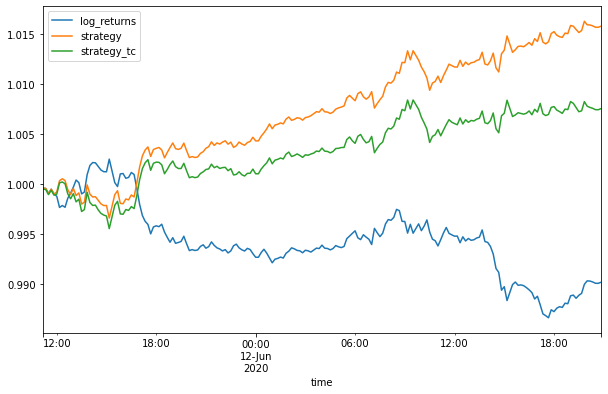

In [46]:
# visualizing the trading strategy on the hold-out set

test['position'] = model.predict(test_[cols])
test['strategy'] = test['position'] * test['log_returns']

# the number of trains
sum(test['strategy'].diff() != 0)

# strategy minus transaction costs
test['strategy_tc'] = np.where(test['position'].diff() != 0,
                                test['strategy'] - ptc,
                                test['strategy'])

# plot
test[['log_returns', 'strategy', 'strategy_tc']].cumsum().apply(np.exp).plot(figsize=(10, 6))


### **Optimal Leverage**

In [51]:
# first annualize the average of the log returns

# multiple by number of 10 minute intervals in that week (len(data)) then
# by the number of weeks in a year
mean = test[['log_returns', 'strategy_tc']].mean() * len(data) * 52
var = test[['log_returns', 'strategy_tc']].var() * len(data) * 52

print(f"Kelly criterion: \n{mean / var}")
print(f".5 Kelly criterion: \n{0.5 * mean / var}")

# thats a leverage of 50:1 which is doable on Oanda

Kelly criterion: 
log_returns   -150.884961
strategy_tc    114.687875
dtype: float64
.5 Kelly criterion: 
log_returns   -75.442481
strategy_tc    57.343938
dtype: float64


<AxesSubplot:xlabel='time'>

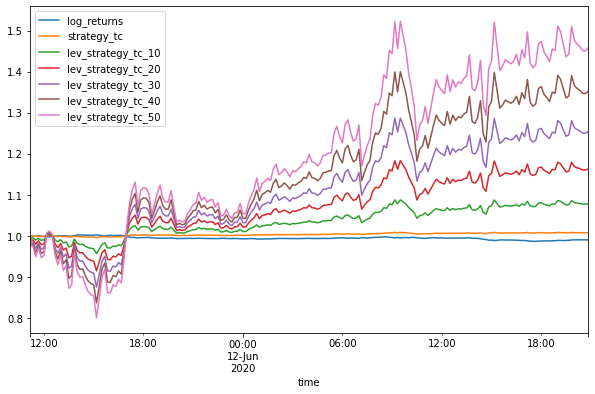

In [52]:
# plot strategies with the leverages

to_plot = ['log_returns', 'strategy_tc']

for lev in [10, 20, 30, 40, 50]:
    label = f"lev_strategy_tc_{lev}"
    # this is multplying the lever by log returns! Not exactly accurate I think
    test[label] = test['strategy_tc'] * lev
    to_plot.append(label)

test[to_plot].cumsum().apply(np.exp).plot(figsize=(10, 6))



In [61]:
# The largest dip at about 3:00 pm
test['lev_strategy_tc_50'].cumsum().apply(np.exp).min()

# so you lost 20% of your account equit ($1000)
# this would not trigger a margin call, I believe

0.8004903023405127

In [86]:
# when you actually do the cumulative returns at that minimum,
# its actually worse since in the calculation above, we multiplied
# the lever by the log returns (should be multiplied by gross returns)
# still don't think it would have triggered a margin call though. 
250000 * test['strategy_tc'].cumsum().apply(np.exp).min() - 250000

-1110.1819755583128

<AxesSubplot:xlabel='time'>

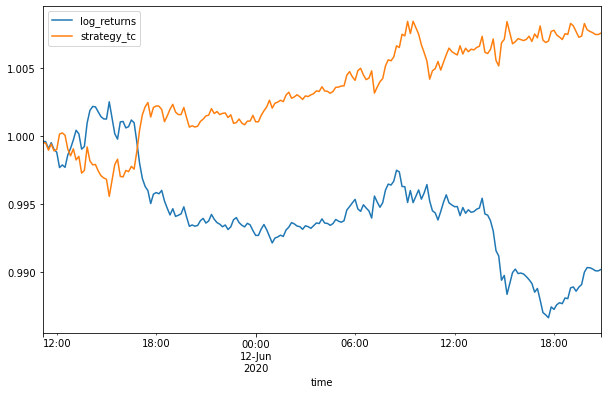

In [69]:
# zooming in on the buy and hold and the non-levered strategy
# The effect of the transaction costs are probably underestimated too
# since they are also multipled by the log returns
test[['log_returns', 'strategy_tc']].cumsum().apply(np.exp).plot(figsize=(10, 6))

### **Risk Analysis**

In [94]:
pd.set_option('display.max_rows', 100)
# lets look at maximum drawdown (largest loss (dip) after a recent high) and longest maximum drawdown (longest period that the strategy needs to get back to a recent high)

# we were actually analyzing the max drawdown right above to see what would happen with the margin call
# possibility

# lets assume that there are no adjustments with regard to the equity over time, no matter the performance

equity = 5000
lev_strat = 'lev_strategy_tc_50'

risk = pd.DataFrame(test[lev_strat])

risk['equity'] = risk[lev_strat].cumsum().apply(np.exp) * equity
risk['cummax'] = risk['equity'].cummax()
risk['drawdown'] = risk['cummax'] - risk['equity']
print(f"Max drawdown for {lev_strat} is: {risk['drawdown'].max()} \n and this occurs at {risk['drawdown'].idxmax()}")
# as you can see by the plot below, this is due to the later drawdown
# when our equity is already trending up. The earlier drawdown is what 
# we're afraid of! 
risk.head()

Max drawdown for lev_strategy_tc_50 is: 1451.7581820292835 
 and this occurs at 2020-06-12 10:30:00


,lev_strategy_tc_50,equity,cummax,drawdown
time,,,,
2020-06-11 11:10:00,-0.024658,4878.218617,4878.218617,0.000000
2020-06-11 11:20:00,-0.001320,4871.782945,4878.218617,6.435672
2020-06-11 11:30:00,-0.025970,4746.892443,4878.218617,131.326174
2020-06-11 11:40:00,0.022009,4852.525812,4878.218617,25.692805
2020-06-11 11:50:00,-0.024651,4734.368880,4878.218617,143.849737


<AxesSubplot:xlabel='time'>

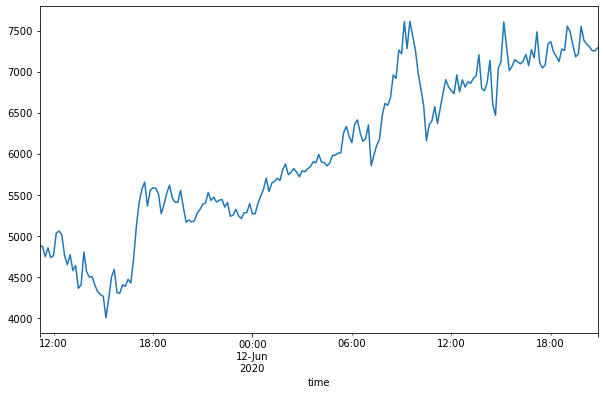

In [93]:
risk['equity'].plot(figsize=(10, 6))

Longest drawdown is: 7.33 hours


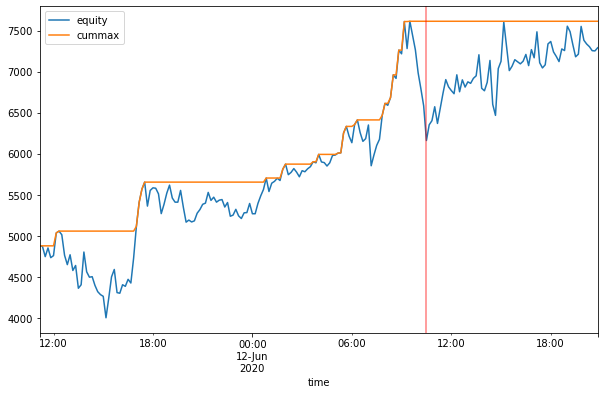

In [100]:
# longest drawdown time
# a new high is characterized by a drawdown of 0

temp = risk['drawdown'][risk['drawdown'] == 0]
# essentially subtract array of n = 2 : end highs and arragy of n = 1 : end - 1
periods = (temp.index[1:].to_pydatetime() - temp.index[:-1].to_pydatetime())
t_per = periods.max()
print(f"Longest drawdown is: {np.round(t_per.seconds / 60 / 60, 2)} hours")

risk[['equity', 'cummax']].plot(figsize=(10, 6))
plt.axvline(risk['drawdown'].idxmax(), c='r', alpha=0.5)

### **Value at Risk**

- when you want to look at the odds of losing greater than or equal to a certain amount at the left tail of the PnL distribution

- What are the worst case scenarios and what are their odds? 

- The left tail of the PnL distribution is highly unlikely, but what loss values occupy that space? What is the 1st percentile, 3rd percentile, and 5th percentile of your PnL density function? 

-e.g. 95% VaR of $1 million means there is a 5% chance of losing this amount or greater. is the odds of losing an amount greater than or equal to the value at the 5th percentile of the PnL PDF

In [105]:
# percentiles
percs = [.01, .1, 1., 2.5, 5.0, 10.0]

risk['log_returns'] = np.log(risk['equity'] / risk['equity'].shift(1))

VaR = scs.scoreatpercentile(equity * risk['log_returns'], percs)

def print_var():
    print(f"Confidence Interval     Value-at-Risk")
    print(33 * '-')
    for pair in zip(percs, VaR):
        print(f"{100 - pair[0]}      {-pair[1]}")

print_var()


# these are you worst possible losses in one bar (in this case 10 minutes)

Confidence Interval     Value-at-Risk
---------------------------------
99.99      406.4665159462215
99.9      403.4099740014485
99.0      330.9886210066835
97.5      307.3140117743535
95.0      252.39959426174622
90.0      156.57063888233148


In [106]:
risk.head()

,lev_strategy_tc_50,equity,cummax,drawdown,log_returns
time,,,,,
2020-06-11 11:10:00,-0.024658,4878.218617,4878.218617,0.000000,NaN
2020-06-11 11:20:00,-0.001320,4871.782945,4878.218617,6.435672,-0.001320
2020-06-11 11:30:00,-0.025970,4746.892443,4878.218617,131.326174,-0.025970
2020-06-11 11:40:00,0.022009,4852.525812,4878.218617,25.692805,0.022009
2020-06-11 11:50:00,-0.024651,4734.368880,4878.218617,143.849737,-0.024651


In [112]:
# downsample from minute bars to hour bars
# take the last datapoint for the hour datapoints
hourly = risk.resample('1H', label='right').last()
# need to recalculate log returns for new time frequency
hourly['log_returns'] = np.log(hourly['equity'] /hourly['equity'].shift(1))
VaR = scs.scoreatpercentile(equity * hourly['log_returns'], percs)
print_var()
# obviously, the worst case losses increase as you consider a longer time span

Confidence Interval     Value-at-Risk
---------------------------------
99.99      631.2121572276258
99.9      629.4240853157498
99.0      611.5433661969905
97.5      581.742167665725
95.0      313.7772375317253
90.0      154.26786630545251


### **Save the Model**

In [115]:
# once we're good with the backtesting, capital management, and risk management analysis,
# we can go ahead and save the model, as well as other import information 

algorithm = {'model': model, 'mu': mu, 'std': std}
# 'wb' means write to binary
pickle.dump(algorithm, open('../../data/algorithm.pkl', 'wb'))